✅ Modelo cargado: models\bestmodel_fold1.h5
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 256, 256, 4)  0           ['input_1[0][0]']                
                                                                                                  
 proj_4to3 (Conv2D)             (None, 256, 256, 3)  15          ['sequential[0][0]']             
                                                                                                  
 model (Functional)             [(None, 128, 128

Evaluando imágenes: 100%|██████████| 225/225 [02:23<00:00,  1.57img/s]


📊 Métricas medias:
  - Precision: 0.2372
  - Recall  : 0.1474
  - F1      : 0.1517
  - Iou     : 0.1253

🎨 Mostrando 3 muestras aleatorias…


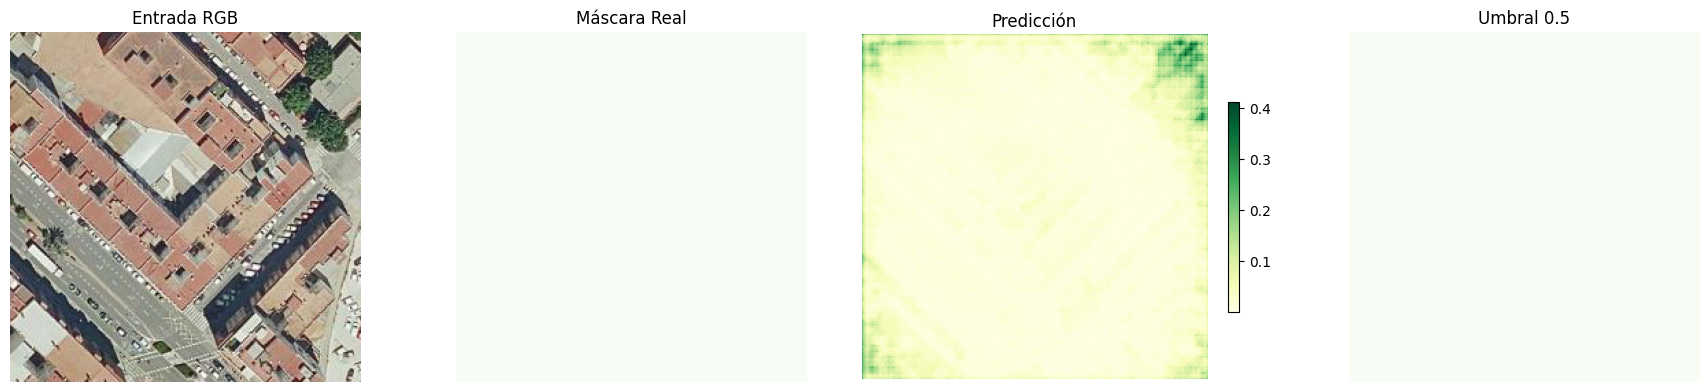

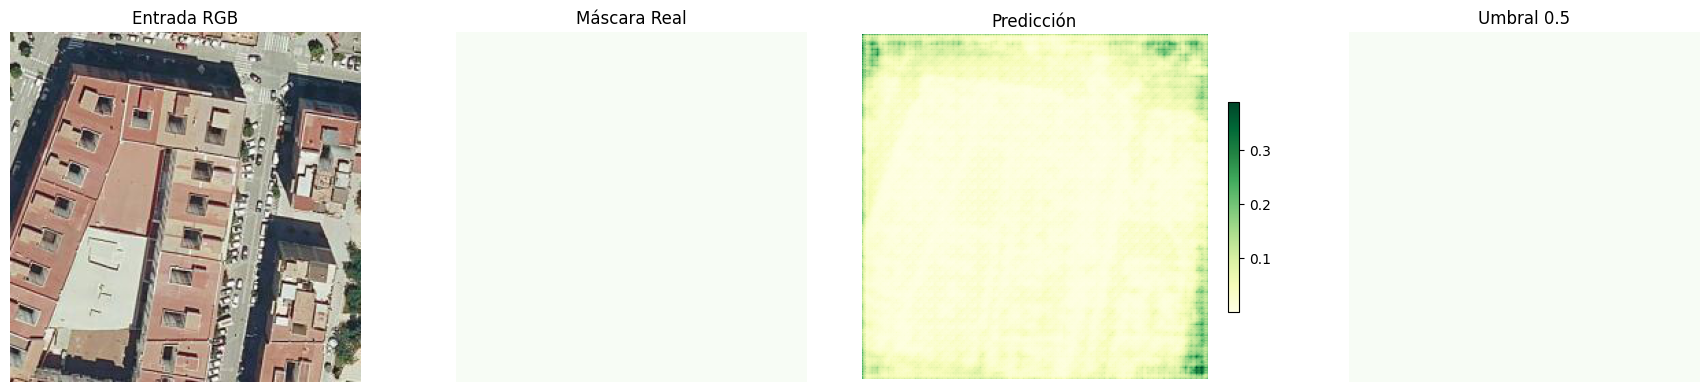

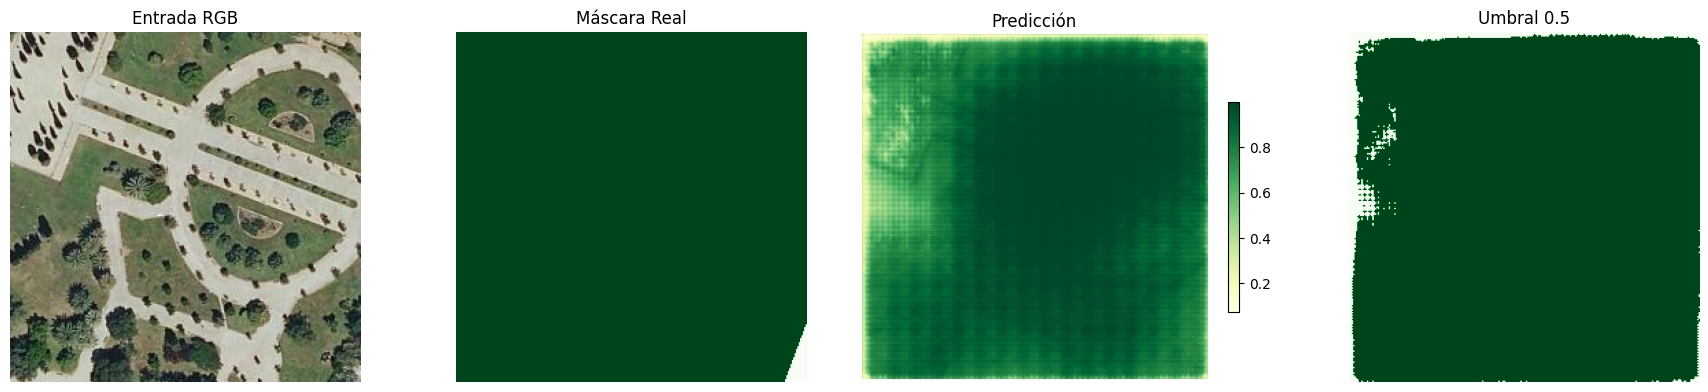

Threshold 0.3: Precision=0.701, Recall=0.673, IoU=0.523
Threshold 0.5: Precision=0.782, Recall=0.569, IoU=0.491
Threshold 0.7: Precision=0.857, Recall=0.462, IoU=0.429

✅ Informe guardado en evaluation_report.csv


In [ ]:
# notebooks/04_Visualizar_Predicciones.ipynb

# ------------------------------------------------------------------
# 0. IMPORTS Y CONFIG
# ------------------------------------------------------------------
from pathlib import Path
import numpy as np
import tensorflow as tf
import rasterio
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import sys

import warnings
from rasterio.errors import NotGeoreferencedWarning
from tqdm import tqdm
# Suprimir solo los warnings de Rasterio
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

# Añadir scripts al path
PROJECT_ROOT = Path().resolve().parent
SCRIPT_DIR   = PROJECT_ROOT / "scripts"
if str(SCRIPT_DIR) not in sys.path:
    sys.path.append(str(SCRIPT_DIR))

from model_utils import dice_loss

# ------------------------------------------------------------------
# 1. PATHS
# ------------------------------------------------------------------
RAW_DIR       = PROJECT_ROOT / "data" / "raw" / "pnoa"
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
MODEL_PATH    = PROJECT_ROOT / "models" / "bestmodel_fold1.h5"  # o final_model.h5 o best_model.h5

# ------------------------------------------------------------------
# 2. UTILIDADES DE PREPROCESADO CON 4 CANALES
# ------------------------------------------------------------------

def compute_exg(img: tf.Tensor) -> tf.Tensor:
    """
    Calcula el ExG (Excess Green) para un tensor RGB HxWx3 en [0,1].
    Retorna un tensor HxWx1.
    """
    R, G, B = tf.split(img, 3, axis=-1)
    exg = 2*G - R - B
    mn = tf.reduce_min(exg)
    mx = tf.reduce_max(exg)
    return (exg - mn) / (mx - mn + 1e-6)


def load_image_and_mask(tile_jpg: Path, target_size=(256,256)):
    """
    Carga JPEG y su máscara TIFF, normaliza a [0,1], calcula ExG y devuelve ambos.
    img4: HxWx4 (RGB + ExG), msk: HxW binario.
    """
    mask_tif = PROCESSED_DIR / f"{tile_jpg.stem}_MASK.tif"
    assert mask_tif.exists(), f"Falta máscara para {tile_jpg.name}"
    # Leer JPEG canales 1,2,3
    with rasterio.open(tile_jpg) as src:
        img = src.read([1,2,3]).transpose(1,2,0).astype(np.float32)
    # Redimensionar y normalizar
    img = tf.image.resize(img, target_size) / 255.0
    # Calcular ExG y concatenar
    exg  = compute_exg(img)
    img4 = tf.concat([img, exg], axis=-1)
    # Leer y procesar máscara
    with rasterio.open(mask_tif) as src:
        msk = src.read(1).astype(np.uint8)
    msk = tf.image.resize(msk[...,None], target_size, method='nearest')
    msk = tf.squeeze(msk).numpy().astype(int)
    return img4.numpy(), msk

# ------------------------------------------------------------------
# 3. CARGAR MODELO
# ------------------------------------------------------------------
model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={'dice_loss': dice_loss},
    compile=False
)
print(f"✅ Modelo cargado: {MODEL_PATH.relative_to(PROJECT_ROOT)}")
model.summary()

# ------------------------------------------------------------------
# 4. EVALUACIÓN GLOBAL
# ------------------------------------------------------------------
print("\n🧪 Evaluando todas las imágenes…")
all_metrics = []
predictions = []

jpgs = sorted(RAW_DIR.glob("valencia_tile_*.jpg"))
for tile in tqdm(jpgs, desc="Evaluando imágenes", unit="img"):
    img4, msk = load_image_and_mask(tile)
    pred     = model.predict(img4[None], verbose=0)[0,:,:,0]
    metrics  = {
        'precision': precision_score(msk.flatten(), (pred.flatten()>0.5).astype(int), zero_division=0),
        'recall':    recall_score(msk.flatten(), (pred.flatten()>0.5).astype(int), zero_division=0),
        'f1':        f1_score(msk.flatten(), (pred.flatten()>0.5).astype(int), zero_division=0),
        'iou':       jaccard_score(msk.flatten(), (pred.flatten()>0.5).astype(int), zero_division=0)
    }
    all_metrics.append(metrics)
    predictions.append((img4[..., :3], msk, pred))  # mantengo RGB para visualización

# Promediar métricas
avg = {k: np.mean([m[k] for m in all_metrics]) for k in all_metrics[0]}
print("📊 Métricas medias:")
for k,v in avg.items():
    print(f"  - {k.capitalize():8s}: {v:.4f}")

# ------------------------------------------------------------------
# 5. VISUALIZAR EJEMPLOS
# ------------------------------------------------------------------
print(f"\n🎨 Mostrando 3 muestras aleatorias…")
import random

def plot_sample_prediction(img_rgb, msk, pred, threshold=0.5):
    fig, axes = plt.subplots(1,4, figsize=(18,4))
    axes[0].imshow(img_rgb);    axes[0].set_title("Entrada RGB");      axes[0].axis('off')
    axes[1].imshow(msk, cmap='Greens'); axes[1].set_title("Máscara Real"); axes[1].axis('off')
    im = axes[2].imshow(pred, cmap='YlGn'); axes[2].set_title("Predicción"); axes[2].axis('off')
    fig.colorbar(im, ax=axes[2], shrink=0.6)
    axes[3].imshow(pred>threshold, cmap='Greens')
    axes[3].set_title(f"Umbral {threshold}"); axes[3].axis('off')
    plt.tight_layout()
    plt.show()

for img_rgb, msk, pred in random.sample(predictions, 3):
    plot_sample_prediction(img_rgb, msk, pred)

# ------------------------------------------------------------------
# 6. BALANCE DE THRESHOLDS (opcional)
# ------------------------------------------------------------------
thresholds = [0.3, 0.5, 0.7]
for t in thresholds:
    y_true = np.concatenate([msk.flatten() for _,msk,_ in predictions])
    y_pred = np.concatenate([pred.flatten() for _,_,pred in predictions])
    m = {
        'precision': precision_score(y_true, (y_pred>t).astype(int), zero_division=0),
        'recall':    recall_score(y_true, (y_pred>t).astype(int), zero_division=0),
        'iou':       jaccard_score(y_true, (y_pred>t).astype(int), zero_division=0)
    }
    print(f"Threshold {t}: Precision={m['precision']:.3f}, Recall={m['recall']:.3f}, IoU={m['iou']:.3f}")

# ------------------------------------------------------------------
# 7. Guardar informe a CSV
# ------------------------------------------------------------------
import pandas as pd
df = pd.DataFrame(all_metrics)
df.to_csv(PROJECT_ROOT/"evaluation_report.csv", index=False)
print(f"\n✅ Informe guardado en evaluation_report.csv")
